# SVM Modifications: Pre-processing using different methods + SVM classifier
Dataset used: IY014 - 10-fold difference in parameter spaces

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from utils.data_loader import load_loader_from_disk

In [2]:
# ==========================================
# CONFIGURATION
# ==========================================
# 10-fold change experiments (from IY014)
EXPERIMENTS = [
    {
        "name": "1. Baseline (Sobol)",
        "data_dir": "../EXP-26-IY014/data",
        "csv_name": "IY014_simulation_parameters_sobol.csv",
        "train_save_path":"IY014_static_train.pt",
        "val_save_path":"IY014_static_val.pt",
        "test_save_path":"IY014_static_test.pt",
        # "data_dir": "../EXP-25-IY011/data",
        # "csv_name": "IY011_simulation_parameters_sobol.csv",
        "color": "black"
    },
    {
        "name": "2. Mu Variation",
        # "data_dir": "data_mu_variation",
        "data_dir": "../EXP-25-IY011/data_mu_variation",
        "csv_name": "IY011_simulation_mu_parameters_sobol.csv",
        "train_save_path":"IY014_static_train.pt",
        "val_save_path":"IY014_static_val.pt",
        "test_save_path":"IY014_static_test.pt",
        "color": "blue"
    },
    {
        "name": "3. CV Variation",
        "data_dir": "../EXP-26-IY014/data_cv_variation",
        "csv_name": "IY014_simulation_cv_parameters_sobol.csv",
        "train_save_path":"IY014_static_train.pt",
        "val_save_path":"IY014_static_val.pt",
        "test_save_path":"IY014_static_test.pt",
        # "data_dir": "../EXP-25-IY011/data_cv_variation",
        # "csv_name": "IY011_simulation_cv_parameters_sobol.csv",
        "color": "green"
    },
    {
        "name": "4. Tac Variation",
        "data_dir": "../EXP-26-IY014/data_t_ac_variation",
        "csv_name": "IY014_simulation_t_ac_parameters_sobol.csv",
        "train_save_path":"IY014_static_train.pt",
        "val_save_path":"IY014_static_val.pt",
        "test_save_path":"IY014_static_test.pt",
        # "data_dir": "../EXP-25-IY011/data_t_ac_variation",
        # "csv_name": "IY011_simulation_t_ac_parameters_sobol.csv",
        "color": "red"
    }
]

# ==========================================
BASELINE_DATA_ROOT = Path(EXPERIMENTS[0]["data_dir"])
MU_DATA_ROOT = Path(EXPERIMENTS[1]["data_dir"])
CV_DATA_ROOT = Path(EXPERIMENTS[2]["data_dir"]) 
TAC_DATA_ROOT = Path(EXPERIMENTS[3]["data_dir"])

baseline_train_save_path = BASELINE_DATA_ROOT / EXPERIMENTS[0]["train_save_path"]
baseline_val_save_path   = BASELINE_DATA_ROOT / EXPERIMENTS[0]["val_save_path"]
baseline_test_save_path  = BASELINE_DATA_ROOT / EXPERIMENTS[0]["test_save_path"]
baseline_train_loader = load_loader_from_disk(baseline_train_save_path)
baseline_val_loader = load_loader_from_disk(baseline_val_save_path)
baseline_test_loader = load_loader_from_disk(baseline_test_save_path)

cv_train_save_path = CV_DATA_ROOT / EXPERIMENTS[2]["train_save_path"]
cv_val_save_path   = CV_DATA_ROOT / EXPERIMENTS[2]["val_save_path"]
cv_test_save_path  = CV_DATA_ROOT / EXPERIMENTS[2]["test_save_path"]
cv_train_loader = load_loader_from_disk(cv_train_save_path)
cv_val_loader = load_loader_from_disk(cv_val_save_path)
cv_test_loader = load_loader_from_disk(cv_test_save_path)   

tac_train_save_path = TAC_DATA_ROOT / EXPERIMENTS[3]["train_save_path"]
tac_val_save_path   = TAC_DATA_ROOT / EXPERIMENTS[3]["val_save_path"]
tac_test_save_path  = TAC_DATA_ROOT / EXPERIMENTS[3]["test_save_path"]
tac_train_loader = load_loader_from_disk(tac_train_save_path)
tac_val_loader = load_loader_from_disk(tac_val_save_path)
tac_test_loader = load_loader_from_disk(tac_test_save_path)

mu_train_save_path = MU_DATA_ROOT / EXPERIMENTS[1]["train_save_path"]
mu_val_save_path   = MU_DATA_ROOT / EXPERIMENTS[1]["val_save_path"]
mu_test_save_path  = MU_DATA_ROOT / EXPERIMENTS[1]["test_save_path"]
mu_train_loader = load_loader_from_disk(mu_train_save_path)
mu_val_loader = load_loader_from_disk(mu_val_save_path)
mu_test_loader = load_loader_from_disk(mu_test_save_path)   

📂 Loading static data from ../EXP-26-IY014/data/IY014_static_train.pt...
📂 Loading static data from ../EXP-26-IY014/data/IY014_static_val.pt...
📂 Loading static data from ../EXP-26-IY014/data/IY014_static_test.pt...
📂 Loading static data from ../EXP-26-IY014/data_cv_variation/IY014_static_train.pt...
📂 Loading static data from ../EXP-26-IY014/data_cv_variation/IY014_static_val.pt...
📂 Loading static data from ../EXP-26-IY014/data_cv_variation/IY014_static_test.pt...
📂 Loading static data from ../EXP-26-IY014/data_t_ac_variation/IY014_static_train.pt...
📂 Loading static data from ../EXP-26-IY014/data_t_ac_variation/IY014_static_val.pt...
📂 Loading static data from ../EXP-26-IY014/data_t_ac_variation/IY014_static_test.pt...
📂 Loading static data from ../EXP-25-IY011/data_mu_variation/IY014_static_train.pt...
📂 Loading static data from ../EXP-25-IY011/data_mu_variation/IY014_static_val.pt...
📂 Loading static data from ../EXP-25-IY011/data_mu_variation/IY014_static_test.pt...


In [3]:
# verify the results seen from training script
def extract_data_for_svm(loader):
    """
    Extracts all batches from a DataLoader and flattens them for SVM input.
    Input X: (Batch, Time, Features) -> Output X: (Total_Samples, Time * Features)
    """
    X_list = []
    y_list = []
    
    print(f"Extracting data from loader for SVM...")
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Move to CPU and convert to numpy
            X_np = X_batch.cpu().numpy()
            y_np = y_batch.cpu().numpy()
            
            # Flatten the time series: 
            # (Batch, Seq_Len, 1) -> (Batch, Seq_Len)
            # This turns the time series into a long feature vector
            X_flat = X_np.reshape(X_np.shape[0], -1)
            
            X_list.append(X_flat)
            y_list.append(y_np)
            
    # Concatenate all batches
    return np.vstack(X_list), np.concatenate(y_list)

# 1. Extract Data dynamically from loaders
X_train_svm, y_train_svm = extract_data_for_svm(baseline_train_loader)
X_test_svm, y_test_svm   = extract_data_for_svm(baseline_test_loader)

print(f"SVM Train Shape: {X_train_svm.shape}")
print(f"SVM Test Shape:  {X_test_svm.shape}")

Extracting data from loader for SVM...
Extracting data from loader for SVM...
SVM Train Shape: (3000, 3623)
SVM Test Shape:  (600, 3623)


# Pure SVM

In [4]:
from classifiers.svm_classifier import svm_classifier
def run_svm(train_loader, test_loader):
    # do a simple SVM as baseline
    X_train_svm, y_train_svm = extract_data_for_svm(train_loader)
    X_test_svm, y_test_svm = extract_data_for_svm(test_loader)

    svm_acc = svm_classifier(X_train_svm, X_test_svm, y_train_svm, y_test_svm)
    return svm_acc

baseline_svm_acc = run_svm(baseline_train_loader, baseline_test_loader)
mu_svm_acc = run_svm(mu_train_loader, mu_test_loader)
cv_svm_acc = run_svm(cv_train_loader, cv_test_loader)
tac_svm_acc = run_svm(tac_train_loader, tac_test_loader)

Extracting data from loader for SVM...


Extracting data from loader for SVM...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== SVM (RBF Kernel) Classification Accuracy: 0.77 ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== SVM (RBF Kernel) Classification Accuracy: 1.00 ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== SVM (RBF Kernel) Classification Accuracy: 0.78 ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== SVM (RBF Kernel) Classification Accuracy: 0.82 ===


# PCA + SVM

In [5]:
def run_pca_svm(train_loader, test_loader, exp_name="Experiment", plotting=False):
    print(f"\n=== Running PCA + SVM on {exp_name} ===")
    
    X_train_svm, y_train_svm = extract_data_for_svm(train_loader)
    X_test_svm, y_test_svm = extract_data_for_svm(test_loader)
    
    # 2. Create the Pipeline
    # PCA -> Scaler -> Classifier
    pipe = Pipeline([
        # PCA: Keep enough components to explain 95% of variance 
        ("project", PCA(n_components=0.95)), 
        
        # StandardScaler: Critical for SVM to normalize features
        # ("rescale", StandardScaler()), 
        
        # SVM: Using RBF kernel with default C=1.0, gamma='scale' (No GridSearch)
        ("classifier", SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
    
    # gridsearch for PCA n_components
    
    # nPCArange = (
    #     range(1, X_train.shape[1] + 1) if X_train.shape[1] < 7 else [3, 4, 5, 6, 7]
    # )
    # params = [{"project__n_components": nPCArange}]
    # grid_pipeline = GridSearchCV(pipe, params, n_jobs=-1, cv=5)
    # grid_pipeline.fit(X_train, y_train)
    # pipe.set_params(**grid_pipeline.best_params_)

    # 3. Fit the Pipeline
    print("Training Pipeline (PCA + SVM)...")
    pipe.fit(X_train_svm, y_train_svm)

    # 4. Check how many components PCA kept
    n_components = pipe.named_steps['project'].n_components_
    print(f"✅ PCA reduced features from {X_train_svm.shape[1]} -> {n_components} components")
    # 5. Evaluate
    print("Evaluating...")
    y_pred = pipe.predict(X_test_svm)
    acc = accuracy_score(y_test_svm, y_pred)
    
    print(f"🏆 {exp_name} Accuracy: {acc:.2%}")
    print("-" * 30)
    
    # Optional: Visualize the Decision Boundary (First 2 PCs only)
    # This helps visualize if the "Hairball" was untangled
    if plotting:
       visualize_pca_boundary(pipe, X_test_svm, y_test_svm, exp_name)
    return acc

def visualize_pca_boundary(pipe, X, y, title):
    """
    Visualizes the decision boundary on the first 2 Principal Components.
    Note: This is an approximation since the SVM uses >2 components.
    """
    pca = pipe.named_steps['project']
    X_pca = pca.transform(X) # Project data to PCA space
    
    plt.figure(figsize=(8, 6))
    
    # Plot Data Points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.5, edgecolors='k')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"{title}: Data in PCA Space")
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# RUN THE EXPERIMENTS
# ==========================================

baseline_pca_svm_acc = run_pca_svm(
    train_loader=baseline_train_loader,
    test_loader=baseline_test_loader,
    exp_name="Baseline"
)

# 1. Run on CV Variation
cv_pca_svm_acc = run_pca_svm(
    train_loader=cv_train_loader,
    test_loader=cv_test_loader,
    exp_name="CV Variation"
)

# 2. Run on Mu Variation
mu_pca_svm_acc = run_pca_svm(
    train_loader=mu_train_loader,
    test_loader=mu_test_loader,
    exp_name="Mu Variation"
)

# 3. Run on Tac Variation
tac_pca_svm_acc = run_pca_svm(
    train_loader=tac_train_loader,
    test_loader=tac_test_loader,
    exp_name="Tac Variation"
)


=== Running PCA + SVM on Baseline ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...
Training Pipeline (PCA + SVM)...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ PCA reduced features from 3623 -> 291 components
Evaluating...
🏆 Baseline Accuracy: 78.17%
------------------------------

=== Running PCA + SVM on CV Variation ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...
Training Pipeline (PCA + SVM)...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ PCA reduced features from 5821 -> 852 components
Evaluating...
🏆 CV Variation Accuracy: 81.33%
------------------------------

=== Running PCA + SVM on Mu Variation ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...
Training Pipeline (PCA + SVM)...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ PCA reduced features from 5021 -> 261 components
Evaluating...
🏆 Mu Variation Accuracy: 99.67%
------------------------------

=== Running PCA + SVM on Tac Variation ===
Extracting data from loader for SVM...
Extracting data from loader for SVM...
Training Pipeline (PCA + SVM)...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ PCA reduced features from 3623 -> 496 components
Evaluating...
🏆 Tac Variation Accuracy: 86.00%
------------------------------


# Feature Extraction + SVM 
Feature extraction done using ``pycatch22`` library.

In [6]:
import pycatch22
import pandas as pd
import numpy as np
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# --- 1. Helper: Extract Catch22 Features ---
def extract_catch22_from_loader(loader, exp_name):
    """
    Iterates through a DataLoader and extracts 22 canonical features per sample.
    Returns: DataFrame (N, 22), Labels (N,)
    """
    features_list = []
    y_list = []
    
    # We iterate manually to keep it simple and safe
    # Catch22 is fast enough that we don't need complex multiprocessing
    print(f"   Extracting Catch22 features for {exp_name}...")
    
    for X_batch, y_batch in tqdm(loader, leave=False):
        X_numpy = X_batch.numpy().squeeze() # (Batch, Time)
        y_numpy = y_batch.numpy().flatten()
        
        for i in range(X_numpy.shape[0]):
            time_series = X_numpy[i, :]
            
            # Catch22 returns a dictionary: {'names': [...], 'values': [...]}
            # We convert it to a simple dict for DataFrame creation
            c22_out = pycatch22.catch22_all(time_series)
            
            # Map names to values
            feat_dict = dict(zip(c22_out['names'], c22_out['values']))
            features_list.append(feat_dict)
            y_list.append(y_numpy[i])
            
    # Convert to DataFrame
    df_features = pd.DataFrame(features_list)
    y_labels = np.array(y_list)
    
    return df_features, y_labels

# --- 2. Main Catch22 + SVM Function ---
def run_catch22_svm(train_loader, test_loader, exp_name="Experiment"):
    print(f"\n=== Running Catch22 + SVM on {exp_name} ===")
    
    # A. Extract
    X_train, y_train = extract_catch22_from_loader(train_loader, f"{exp_name} (Train)")
    X_test, y_test   = extract_catch22_from_loader(test_loader, f"{exp_name} (Test)")
    
    if len(X_train) == 0: return 0.0

    print(f"   Extracted {X_train.shape[1]} C22 features.")
    
    # B. Train SVM
    # Catch22 features have wildly different scales (some are counts, some are decimals)
    # StandardScaler is mandatory.
    print("   Training SVM...")
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
    
    pipe.fit(X_train, y_train)
    
    # C. Evaluate
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"🏆 {exp_name} Catch22 Accuracy: {acc:.2%}")
    
    # D. Feature Importance (Permutation) - Optional Check
    # Since we only have 22 features, we can afford to print the most useful one.
    # Simple variance check:
    # If a feature has 0 variance (same for all files), Catch22 might return NaN or const.
    # We quickly handle NaNs (fill with 0) just in case.
    X_train = X_train.fillna(0)
    
    print("-" * 30)
    return acc

# ==========================================
# EXECUTE
# ==========================================

# 1. Baseline
baseline_catch22_svm_acc = run_catch22_svm(baseline_train_loader, baseline_test_loader, "Baseline")

# 2. CV Variation
cv_catch22_svm_acc = run_catch22_svm(cv_train_loader, cv_test_loader, "CV Variation")

# 3. Mu Variation
mu_catch22_svm_acc = run_catch22_svm(mu_train_loader, mu_test_loader, "Mu Variation")

# 4. Tac Variation
tac_catch22_svm_acc = run_catch22_svm(tac_train_loader, tac_test_loader, "Tac Variation")


=== Running Catch22 + SVM on Baseline ===
   Extracting Catch22 features for Baseline (Train)...


   Extracting Catch22 features for Baseline (Test)...


   Extracted 22 C22 features.
   Training SVM...
🏆 Baseline Catch22 Accuracy: 89.83%
------------------------------

=== Running Catch22 + SVM on CV Variation ===
   Extracting Catch22 features for CV Variation (Train)...


   Extracting Catch22 features for CV Variation (Test)...


   Extracted 22 C22 features.
   Training SVM...
🏆 CV Variation Catch22 Accuracy: 100.00%
------------------------------

=== Running Catch22 + SVM on Mu Variation ===
   Extracting Catch22 features for Mu Variation (Train)...


   Extracting Catch22 features for Mu Variation (Test)...


   Extracted 22 C22 features.
   Training SVM...
🏆 Mu Variation Catch22 Accuracy: 100.00%
------------------------------

=== Running Catch22 + SVM on Tac Variation ===
   Extracting Catch22 features for Tac Variation (Train)...


   Extracting Catch22 features for Tac Variation (Test)...


   Extracted 22 C22 features.
   Training SVM...
🏆 Tac Variation Catch22 Accuracy: 99.83%
------------------------------


# Fourier Transform + SVM

In [7]:
from scipy.fft import fft
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

# --- Helper to get data from loaders ---
def get_data_arrays(loader):
    X_list, y_list = [], []
    for X, y in loader:
        X_list.append(X.numpy().squeeze())
        y_list.append(y.numpy().flatten())
    if len(X_list) == 0: return None, None
    return np.concatenate(X_list), np.concatenate(y_list)

# ==========================================
# METHOD 1: FOURIER TRANSFORM (FFT) + SVM
# ==========================================

class FFTTransformer(BaseEstimator, TransformerMixin):
    """
    Converts Time Domain -> Frequency Domain (Magnitude Spectrum).
    Only keeps the first half (positive frequencies).
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X shape: (Samples, Time)
        # 1. Compute FFT
        fft_vals = fft(X, axis=1)
        
        # 2. Compute Magnitude (Absolute value)
        # We ignore Phase because 'Bursts' can happen at any time (translation invariance)
        fft_mag = np.abs(fft_vals)
        
        # 3. Keep only positive frequencies (First half)
        # Since input is real, the second half is just a mirror
        n = X.shape[1]
        return fft_mag[:, :n//2]

def run_fft_svm(train_loader, test_loader, exp_name="Experiment"):
    print(f"\n=== Running FFT + SVM on {exp_name} ===")
    
    X_train, y_train = get_data_arrays(train_loader)
    X_test, y_test   = get_data_arrays(test_loader)
    
    if X_train is None: return

    # Pipeline: FFT -> Normalize -> SVM
    pipe = Pipeline([
        ("fft", FFTTransformer()),
        ("scaler", StandardScaler()), # Normalize frequency magnitudes
        ("svm", SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
    
    print("   Training FFT-SVM...")
    pipe.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, pipe.predict(X_test))
    print(f"🏆 {exp_name} FFT Accuracy: {acc:.2%}")
    return acc

# 1. FFT + SVM (Expect good results on CV and Tac)
baseline_fft_svm_acc = run_fft_svm(baseline_train_loader, baseline_test_loader, "Baseline")
cv_fft_svm_acc = run_fft_svm(cv_train_loader, cv_test_loader, "CV Variation")
tac_fft_svm_acc = run_fft_svm(tac_train_loader, tac_test_loader, "Tac Variation")
mu_fft_svm_acc = run_fft_svm(mu_train_loader, mu_test_loader, "Mu Variation") # Might struggle if Mu is the only difference and DC component is normalized


=== Running FFT + SVM on Baseline ===
   Training FFT-SVM...
🏆 Baseline FFT Accuracy: 70.67%

=== Running FFT + SVM on CV Variation ===
   Training FFT-SVM...
🏆 CV Variation FFT Accuracy: 62.17%

=== Running FFT + SVM on Tac Variation ===
   Training FFT-SVM...
🏆 Tac Variation FFT Accuracy: 94.67%

=== Running FFT + SVM on Mu Variation ===
   Training FFT-SVM...
🏆 Mu Variation FFT Accuracy: 96.67%


# Binarisation of the time series before SVM

In [8]:

# ==========================================
# METHOD 2: BINARIZATION + SVM
# ==========================================

class BinarizerTransformer(BaseEstimator, TransformerMixin):
    """
    Converts Time Series -> Binary Sequence (0 or 1).
    Threshold is dynamic per sample (e.g., sample mean).
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X shape: (Samples, Time)
        
        # Calculate threshold per sample (Mean)
        # This makes it invariant to 'Mu' (Amplitude)
        thresholds = np.mean(X, axis=1, keepdims=True)
        
        # Binarize: 1 if > mean, else 0
        # We convert to float so SVM can handle it numerically
        X_bin = (X > thresholds).astype(float)
        
        return X_bin

def run_binarization_svm(train_loader, test_loader, exp_name="Experiment"):
    print(f"\n=== Running Binarization + SVM on {exp_name} ===")
    
    X_train, y_train = get_data_arrays(train_loader)
    X_test, y_test   = get_data_arrays(test_loader)
    
    if X_train is None: return

    # Pipeline: Binarize -> SVM
    # Note: StandardScaler might not be strictly necessary for 0/1 data, 
    # but RBF kernels usually prefer it.
    pipe = Pipeline([
        ("binarizer", BinarizerTransformer()),
        ("svm", SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
    
    print("   Training Binary-SVM...")
    pipe.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, pipe.predict(X_test))
    print(f"🏆 {exp_name} Binarization Accuracy: {acc:.2%}")
    return acc

# ==========================================
# EXECUTE EXPERIMENTS
# ==========================================

# 2. Binarization + SVM (Expect excellent results on CV, maybe weak on Tac if fine texture matters)
baseline_binarization_svm_acc = run_binarization_svm(baseline_train_loader, baseline_test_loader, "Baseline")
cv_binarization_svm_acc = run_binarization_svm(cv_train_loader, cv_test_loader, "CV Variation")
tac_binarization_svm_acc = run_binarization_svm(tac_train_loader, tac_test_loader, "Tac Variation")
mu_binarization_svm_acc = run_binarization_svm(mu_train_loader, mu_test_loader, "Mu Variation")


=== Running Binarization + SVM on Baseline ===
   Training Binary-SVM...
🏆 Baseline Binarization Accuracy: 84.33%

=== Running Binarization + SVM on CV Variation ===
   Training Binary-SVM...
🏆 CV Variation Binarization Accuracy: 87.50%

=== Running Binarization + SVM on Tac Variation ===
   Training Binary-SVM...
🏆 Tac Variation Binarization Accuracy: 82.83%

=== Running Binarization + SVM on Mu Variation ===
   Training Binary-SVM...
🏆 Mu Variation Binarization Accuracy: 100.00%


# Comparison of different pre-processing methods

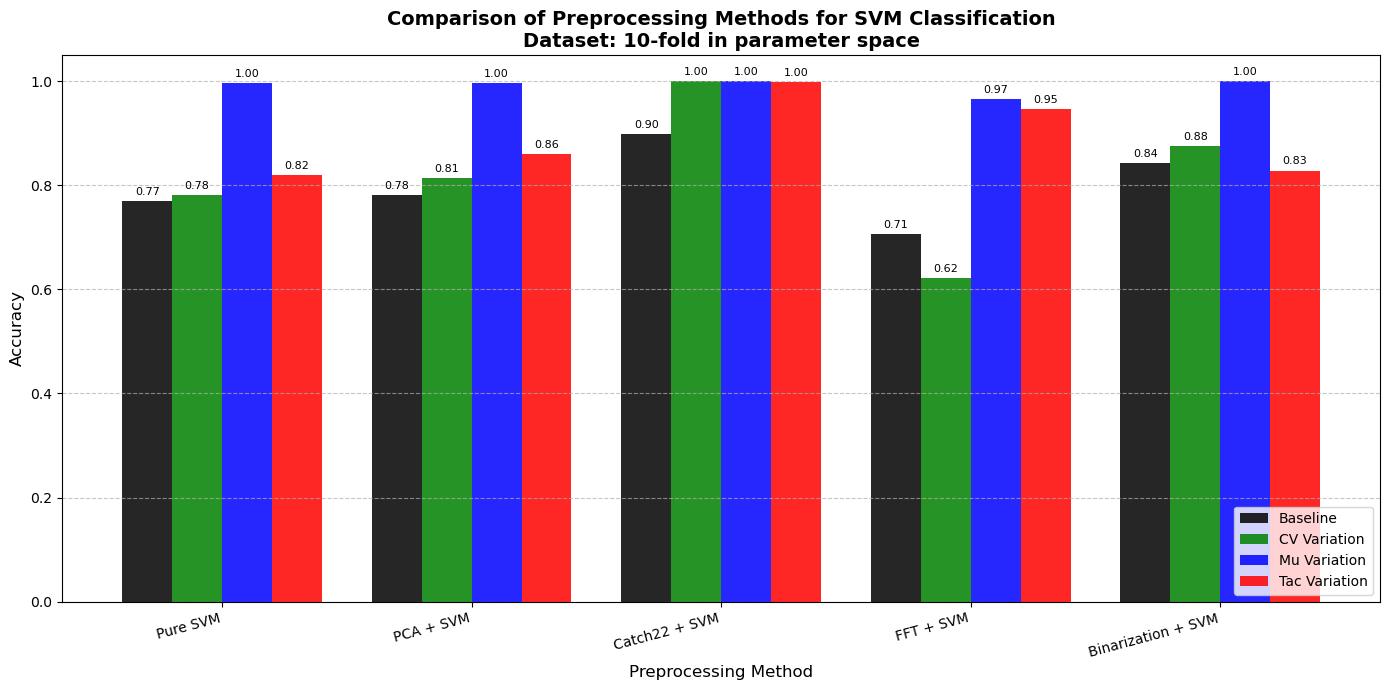

In [9]:
# Collect all accuracy results
methods = ['Pure SVM', 'PCA + SVM', 'Catch22 + SVM', 
           'FFT + SVM', 'Binarization + SVM'
           ]

baseline_accs = [baseline_svm_acc, baseline_pca_svm_acc, baseline_catch22_svm_acc, 
                 baseline_fft_svm_acc, baseline_binarization_svm_acc
                 ]
cv_accs = [cv_svm_acc, cv_pca_svm_acc, cv_catch22_svm_acc, 
           cv_fft_svm_acc, cv_binarization_svm_acc
           ]  
mu_accs = [mu_svm_acc, mu_pca_svm_acc, mu_catch22_svm_acc, 
           mu_fft_svm_acc, mu_binarization_svm_acc
           ]  
tac_accs = [tac_svm_acc, tac_pca_svm_acc, tac_catch22_svm_acc, 
            tac_fft_svm_acc, tac_binarization_svm_acc
            ]  

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(methods))
width = 0.2
alpha = 0.85

# Plot bars for each experiment
baseline_bars = ax.bar(x - width*1.5, baseline_accs, width, alpha=alpha,
                                           label='Baseline', color=EXPERIMENTS[0]["color"])
cv_bars = ax.bar(x - width/2, cv_accs, width, alpha=alpha,       
                                 label='CV Variation', color=EXPERIMENTS[2]["color"])
mu_bars = ax.bar(x + width/2, mu_accs, width, alpha=alpha,
                                 label='Mu Variation', color=EXPERIMENTS[1]["color"])
tac_bars = ax.bar(x + width*1.5, tac_accs, width, alpha=alpha,
                                  label='Tac Variation', color=EXPERIMENTS[3]["color"])

# Add value labels on bars
for bars in [baseline_bars, cv_bars, mu_bars, tac_bars]:
        ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)

# Formatting
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Preprocessing Method', fontsize=12)
ax.set_title('Comparison of Preprocessing Methods for SVM Classification\nDataset: 10-fold in parameter space', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Benchmark catch22 + SVM with Transformer models

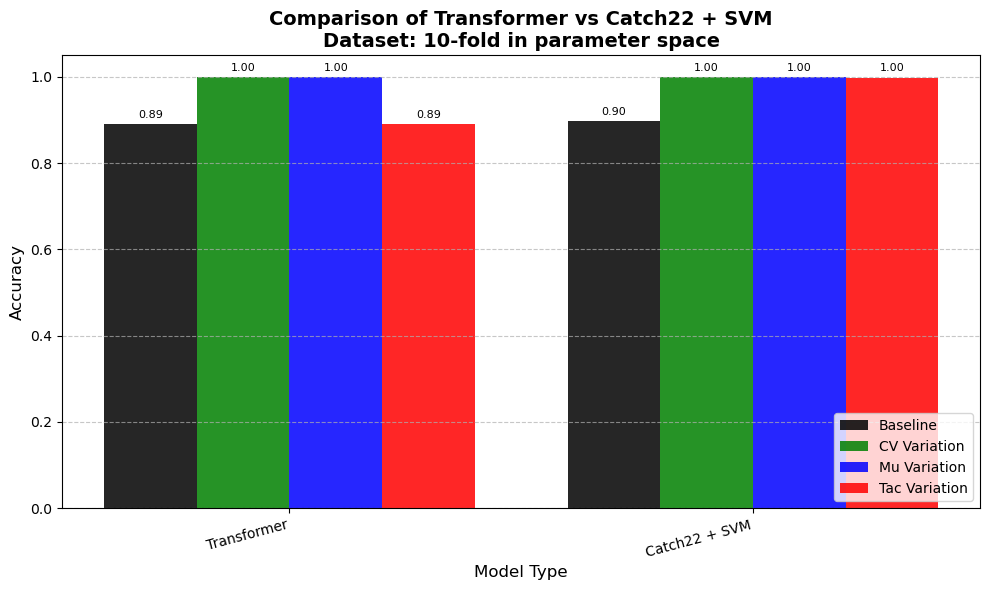

In [10]:
# from IY014_baseline_transformer_training*.py
baseline_transformer_test_acc = 0.89
mu_transformer_test_acc = 1.00
cv_transformer_test_acc = 1.00
tac_transformer_test_acc = 0.89
# plot against catch22 + svm results
methods = ['Transformer', 'Catch22 + SVM']
baseline_accs_ts = [
    baseline_transformer_test_acc,
    baseline_catch22_svm_acc
]
mu_accs_ts = [
    mu_transformer_test_acc,
    mu_catch22_svm_acc
]
cv_accs_ts = [
    cv_transformer_test_acc,
    cv_catch22_svm_acc
]
tac_accs_ts = [
    tac_transformer_test_acc,
    tac_catch22_svm_acc
]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.2
alpha = 0.85
# Plot bars for each experiment
baseline_bars_ts = ax.bar(x - width*1.5, baseline_accs_ts, width, alpha=alpha,
                                           label='Baseline', color=EXPERIMENTS[0]["color"])
cv_bars_ts = ax.bar(x - width/2, cv_accs_ts, width, alpha=alpha,       
                                 label='CV Variation', color=EXPERIMENTS[2]["color"])
mu_bars_ts = ax.bar(x + width/2, mu_accs_ts, width, alpha=alpha,
                                 label='Mu Variation', color=EXPERIMENTS[1]["color"])
tac_bars_ts = ax.bar(x + width*1.5, tac_accs_ts, width, alpha=alpha,
                                  label='Tac Variation', color=EXPERIMENTS[3]["color"]) 

# Add value labels on bars
for bars in [baseline_bars_ts, cv_bars_ts, mu_bars_ts, tac_bars_ts]:
        ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)
        
# Formatting
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_title('Comparison of Transformer vs Catch22 + SVM\nDataset: 10-fold in parameter space', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()